In [11]:
# Importing the necessary libraries

import tensorflow as tf
import albumentations as albu
import numpy as np
import gc
import pickle
import matplotlib.pyplot as plt
from keras.callbacks import CSVLogger
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, precision_score, recall_score, accuracy_score, f1_score
from ModelArchitecture.DiceLoss import dice_metric_loss
from ModelArchitecture import DUCK_Net
# from ImageLoader import ImageLoader2D
import glob

import numpy as np
from PIL import Image
from skimage.io import imread
from tqdm import tqdm


In [12]:
# Checking the number of GPUs available

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [13]:
def load_data(folder_path, is_train, img_height, img_width, images_to_be_loaded, _dataset):
    if is_train:
        IMAGES_PATH = folder_path + 'Originals/'
        MASKS_PATH = folder_path + 'Ground Truth/'
        if _dataset == 'png':
            train_ids = glob.glob(IMAGES_PATH + "*.png")
        else:
            train_ids = glob.glob(IMAGES_PATH + "*.tif")
    else:
        IMAGES_PATH = folder_path + 'images/'
        MASKS_PATH = folder_path + 'labels/'
        train_ids = glob.glob(IMAGES_PATH + "*.bmp")
           

    if images_to_be_loaded == -1:
        images_to_be_loaded = len(train_ids)

    X_train = np.zeros((images_to_be_loaded, img_height, img_width, 3), dtype=np.float32)
    Y_train = np.zeros((images_to_be_loaded, img_height, img_width), dtype=np.uint8)

    print('Resizing training images and masks: ' + str(images_to_be_loaded))
    for n, id_ in tqdm(enumerate(train_ids)):
        if n == images_to_be_loaded:
            break

        image_path = id_
        if is_train:
            mask_path = image_path.replace("Originals", "Ground Truth")
        else:
            mask_path = image_path.replace("images", "labels")
            

        image = imread(image_path)
        mask_ = imread(mask_path)

        mask = np.zeros((img_height, img_width), dtype=np.bool_)

        pillow_image = Image.fromarray(image)

        pillow_image = pillow_image.resize((img_height, img_width))
        image = np.array(pillow_image)

        X_train[n] = image / 255

        pillow_mask = Image.fromarray(mask_)
        pillow_mask = pillow_mask.resize((img_height, img_width), resample=Image.LANCZOS)
        pillow_mask = pillow_mask.convert('L') 
        mask_ = np.array(pillow_mask)

        for i in range(img_height):
            for j in range(img_width):
                if mask_[i, j] >= 127:
                    mask[i, j] = 1

        Y_train[n] = mask

    Y_train = np.expand_dims(Y_train, axis=-1)

    return X_train, Y_train

In [14]:
def random_x_y(x, y, random_state=42):
    # x_train과 y_train의 길이가 동일한지 확인
    assert len(x) == len(y), "x_train and y_train have different lengths."

    # 인덱스를 생성하고 섞음
    indices = np.arange(len(x))
    np.random.seed(random_state)  # random_state 값을 설정
    np.random.shuffle(indices)

    # 인덱스를 사용하여 x_train과 y_train을 섞음
    x_shuffled = x[indices]
    y_shuffled = y[indices]
    return x_shuffled, y_shuffled

In [15]:
# Setting the model parameters

img_size = 352
dataset_type = 'GIANA' # Options: kvasir/cvc-clinicdb/cvc-colondb/etis-laribpolypdb
learning_rate = 1e-4
seed_value = 58800
filters = 34 # Number of filters, the paper presents the results with 17 and 34
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

ct = datetime.now()

model_type = "DuckNet"

progress_path = 'ProgressFull/' + dataset_type + '_progress_csv_' + model_type + '_filters_' + str(filters) +  '_' + str(ct) + '.csv'
progressfull_path = 'ProgressFull/' + dataset_type + '_progress_' + model_type + '_filters_' + str(filters) + '_' + str(ct) + '.txt'
plot_path = 'ProgressFull/' + dataset_type + '_progress_plot_' + model_type + '_filters_' + str(filters) + '_' + str(ct) + '.png'
model_path = 'ModelSaveTensorFlow/' + dataset_type + '/' + model_type + '_filters_' + str(filters) + '_' + str(ct)

EPOCHS = 25
min_loss_for_saving = 0.1901

In [16]:
x_train, y_train = load_data('/aiffel/aiffel/DLthon/data/Polyp_segmentation/train/PNG/',True, img_size, img_size, -1, 'png')
x_train, y_train = random_x_y(x_train, y_train, random_state=seed_value)

Resizing training images and masks: 612


612it [02:15,  4.51it/s]


In [17]:
x_valid, y_valid = load_data('/aiffel/aiffel/DLthon/data/Polyp_segmentation/test/',False, img_size, img_size, -1, 'bmp')
x_train, y_train = random_x_y(x_train, y_train, random_state=seed_value)

Resizing training images and masks: 300


300it [01:21,  3.69it/s]


In [8]:
# Defining the augmentations

aug_train = albu.Compose([
    albu.HorizontalFlip(),
    albu.VerticalFlip(),
    albu.ColorJitter(brightness=(0.6,1.6), contrast=0.2, saturation=0.1, hue=0.01, always_apply=True),
    albu.Affine(scale=(0.5,1.5), translate_percent=(-0.125,0.125), rotate=(-180,180), shear=(-22.5,22), always_apply=True),
])

def augment_images():
    x_train_out = []
    y_train_out = []

    for i in range (len(x_train)):
        ug = aug_train(image=x_train[i], mask=y_train[i])
        x_train_out.append(ug['image'])  
        y_train_out.append(ug['mask'])

    return np.array(x_train_out), np.array(y_train_out)

In [9]:
# load th model
pre_model_path = './ModelSaveTensorFlow/DuckNet34 Cvc-ClinicDb Tf Model'
last_model_path = "./ModelSaveTensorFlow/GIANA/DuckNet_filters_34_2023-07-10 10:48:03.802347"
model = tf.keras.models.load_model(last_model_path, custom_objects={'dice_metric_loss':dice_metric_loss})
# Creating the model
# model = DUCK_Net.create_model(img_height=img_size, img_width=img_size, input_chanels=3, out_classes=1, starting_filters=filters)

In [11]:
# Compiling the model
# 
model.compile(optimizer=optimizer, loss=dice_metric_loss)

이번 학습 전 10 epochs을 실행했고, min val loss가 0.1901 이였습니다.

In [12]:
# # Training the model

step = 0

for epoch in range(0, EPOCHS):
    
    print(f'Training, epoch {epoch}')
    print('Learning Rate: ' + str(learning_rate))

    step += 1
        
    image_augmented, mask_augmented = augment_images()
    image_augmented, mask_augmented = random_x_y(image_augmented, mask_augmented, random_state=seed_value)
    csv_logger = CSVLogger(progress_path, append=True, separator=';')
    
    model.fit(x=image_augmented, y=mask_augmented, epochs=1, batch_size=3, validation_data=(x_valid, y_valid), verbose=1, callbacks=[csv_logger])
    
    prediction_valid = model.predict(x_valid, verbose=0, batch_size=3)
    loss_valid = dice_metric_loss(y_valid, prediction_valid)
    
    loss_valid = loss_valid.numpy()
    print("Loss Validation: " + str(loss_valid))
    # test는 진행하지 않음
#     prediction_test = model.predict(x_test, verbose=0, batch_size=3)
#     loss_test = dice_metric_loss(y_test, prediction_test)
#     loss_test = loss_test.numpy()
#     print("Loss Test: " + str(loss_test)) 
        
    with open(progressfull_path, 'a') as f:
        f.write('epoch: ' + str(epoch) + '\nval_loss: ' + str(loss_valid) + '\n\n\n')
#         f.write('epoch: ' + str(epoch) + '\nval_loss: ' + str(loss_valid) + '\ntest_loss: ' + str(loss_test) + '\n\n\n')
    
    if min_loss_for_saving > loss_valid:
        min_loss_for_saving = loss_valid
        print("Saved model with val_loss: ", loss_valid)
        model.save(model_path)
        
    del image_augmented
    del mask_augmented
    print(epoch, ': end')
    gc.collect()

Training, epoch 0
Learning Rate: 0.0001
204/204 [==============================] - 496s 2s/step - loss: 0.0696 - val_loss: 0.2197
Loss Validation: 0.23239297
0 : end
Training, epoch 1
Learning Rate: 0.0001
204/204 [==============================] - 431s 2s/step - loss: 0.0713 - val_loss: 0.2765
Loss Validation: 0.29386127
1 : end
Training, epoch 2
Learning Rate: 0.0001
204/204 [==============================] - 431s 2s/step - loss: 0.0720 - val_loss: 0.3147
Loss Validation: 0.35258967
2 : end
Training, epoch 3
Learning Rate: 0.0001
204/204 [==============================] - 431s 2s/step - loss: 0.0681 - val_loss: 0.2819
Loss Validation: 0.3151251
3 : end
Training, epoch 4
Learning Rate: 0.0001
204/204 [==============================] - 431s 2s/step - loss: 0.0743 - val_loss: 0.2123
Loss Validation: 0.22009766
4 : end
Training, epoch 5
Learning Rate: 0.0001
204/204 [==============================] - 432s 2s/step - loss: 0.0702 - val_loss: 0.2096
Loss Validation: 0.22614211
5 : end
Train

In [18]:
# Computing the metrics and saving the results
last_model_path = "./ModelSaveTensorFlow/GIANA/DuckNet_filters_34_2023-07-10 10:48:03.802347"
print("Loading the model")
if min_loss_for_saving == 0.1901:
    model = tf.keras.models.load_model(last_model_path, custom_objects={'dice_metric_loss':dice_metric_loss})
else:
    model = tf.keras.models.load_model(model_path, custom_objects={'dice_metric_loss':dice_metric_loss})

prediction_train = model.predict(x_train, batch_size=3)
prediction_valid = model.predict(x_valid, batch_size=3)

print("Predictions done")

dice_train = f1_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
dice_valid = f1_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Dice finished")


miou_train = jaccard_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
miou_valid = jaccard_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Miou finished")


precision_train = precision_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                  np.ndarray.flatten(prediction_train > 0.5))
precision_valid = precision_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                  np.ndarray.flatten(prediction_valid > 0.5))

print("Precision finished")


recall_train = recall_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                            np.ndarray.flatten(prediction_train > 0.5))
recall_valid = recall_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                            np.ndarray.flatten(prediction_valid > 0.5))

print("Recall finished")


accuracy_train = accuracy_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                np.ndarray.flatten(prediction_train > 0.5))
accuracy_valid = accuracy_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                np.ndarray.flatten(prediction_valid > 0.5))


print("Accuracy finished")


final_file = 'results_' + model_type + '_' + str(filters) + '_' + dataset_type + '.txt'
print(final_file)

with open(final_file, 'a') as f:
    f.write(dataset_type + '\n\n')
    f.write('dice_train: ' + str(dice_train) + ' dice_valid: ' + str(dice_valid)  + '\n\n')
    f.write('miou_train: ' + str(miou_train) + ' miou_valid: ' + str(miou_valid) + '\n\n')
    f.write('precision_train: ' + str(precision_train) + ' precision_valid: ' + str(precision_valid) + '\n\n')
    f.write('recall_train: ' + str(recall_train) + ' recall_valid: ' + str(recall_valid) + '\n\n')
    f.write('accuracy_train: ' + str(accuracy_train) + ' accuracy_valid: ' + str(accuracy_valid) + '\n\n\n\n')
print('File done')


print('dice_train: ' + str(dice_train) + ' dice_valid: ' + str(dice_valid) )
print('miou_train: ' + str(miou_train) + ' miou_valid: ' + str(miou_valid) )
print('precision_train: ' + str(precision_train) + ' precision_valid: ' + str(precision_valid) )
print('recall_train: ' + str(recall_train) + ' recall_valid: ' + str(recall_valid) )
print('accuracy_train: ' + str(accuracy_train) + ' accuracy_valid: ' + str(accuracy_valid) )

Loading the model
Predictions done
Dice finished
Miou finished
Precision finished
Recall finished
Accuracy finished
results_DuckNet_34_GIANA.txt
File done
dice_train: 0.9498155764490488 dice_valid: 0.8119329801191121
miou_train: 0.9044274083188849 miou_valid: 0.6834067157259478
precision_train: 0.9452604270263462 precision_valid: 0.7893693440277356
recall_train: 0.954414840403172 recall_valid: 0.8358245084481042
accuracy_train: 0.9907548865577567 accuracy_valid: 0.9802050243199035


반올림 해서 0.7 이상 나왔습니다!

In [23]:
print('dice_train: {:.1f} dice_valid: {:.1f}'.format(round(dice_train, 1), round(dice_valid, 1)))
print('miou_train: {:.1f} miou_valid: {:.1f}'.format(round(miou_train, 1), round(miou_valid, 1)))
print('precision_train: {:.1f} precision_valid: {:.1f}'.format(round(precision_train, 1), round(precision_valid, 1)))
print('recall_train: {:.1f} recall_valid: {:.1f}'.format(round(recall_train, 1), round(recall_valid, 1)))
print('accuracy_train: {:.1f} accuracy_valid: {:.1f}'.format(round(accuracy_train, 1), round(accuracy_valid, 1)))

dice_train: 0.9 dice_valid: 0.8
miou_train: 0.9 miou_valid: 0.7
precision_train: 0.9 precision_valid: 0.8
recall_train: 1.0 recall_valid: 0.8
accuracy_train: 1.0 accuracy_valid: 1.0


In [43]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def show_image(i, th):
    ground_truth = y_valid[i]
    ground_truth_out = np.zeros((ground_truth.shape[0], ground_truth.shape[1]), dtype=np.uint8)
    for x in range(ground_truth_out.shape[0]):
        for y in range(ground_truth_out.shape[1]):
            if ground_truth[x, y] > th:
                ground_truth_out[x, y] = 255
    ground_truth_out = Image.fromarray(ground_truth_out)

    output = prediction_valid[i]
    predict = np.zeros((output.shape[0], output.shape[1]), dtype=np.uint8)
    for x in range(predict.shape[0]):
        for y in range(predict.shape[1]):
            if output[x, y] > th:
                predict[x, y] = 255
    output = Image.fromarray(predict)

    background = x_valid[i] * 255
    background = background.astype(np.uint8)
    background = Image.fromarray(background).convert('RGB')

    output = output.convert('RGB')
    output = output.resize(background.size)

    total = Image.blend(background, output, alpha=0.5)

    # Create a new figure with a 2x2 grid layout
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))

    axs[0, 0].imshow(ground_truth_out, cmap='gray')
    axs[0, 0].set_title("Ground Truth")

    axs[0, 1].imshow(output, cmap='gray')
    axs[0, 1].set_title("Predicted Output")

    axs[1, 0].imshow(background)
    axs[1, 0].set_title("Original")

    axs[1, 1].imshow(total)
    axs[1, 1].set_title("Result Overlay")

    # Remove the axis labels
    for ax in axs.flat:
        ax.axis('off')

    plt.show()


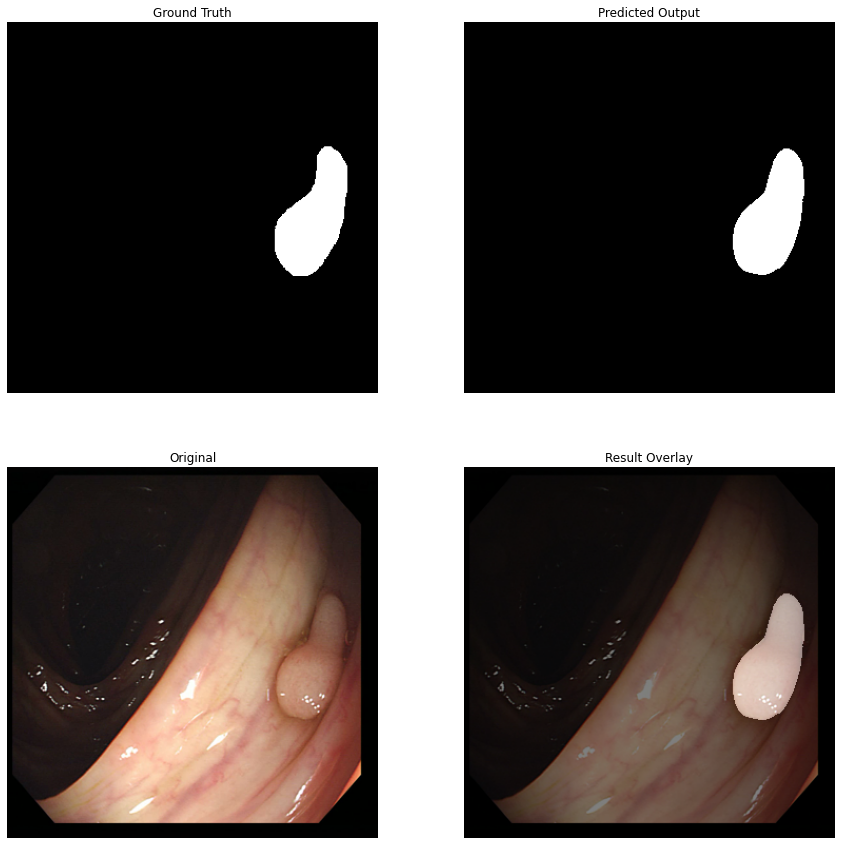

In [44]:
show_image(7, 0.5)

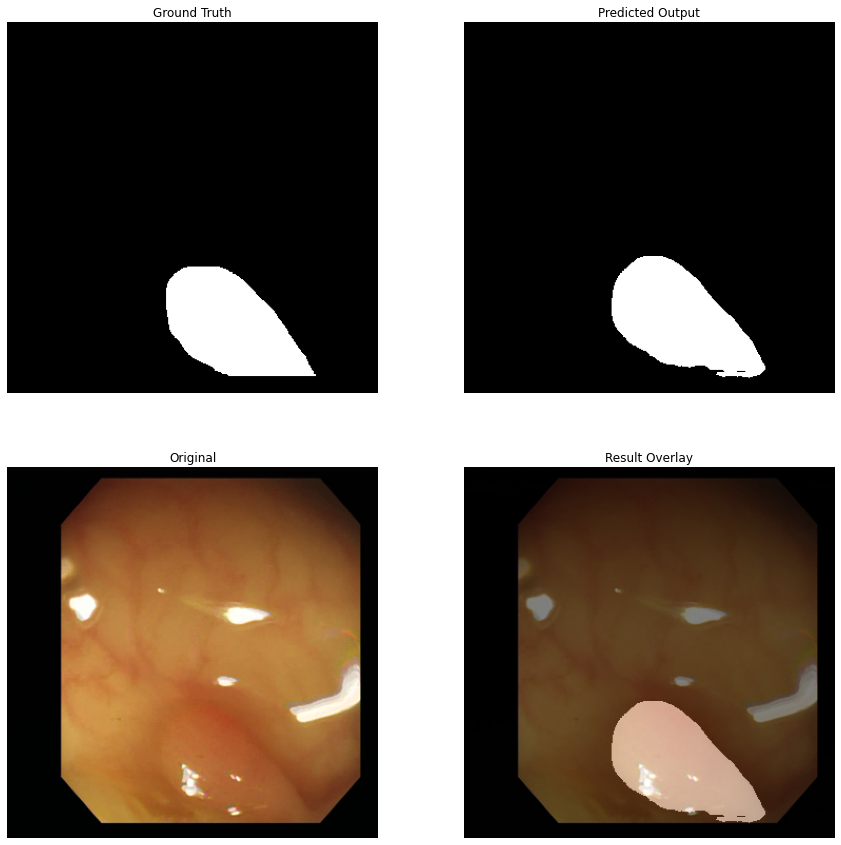

In [45]:
show_image(22, 0.5)

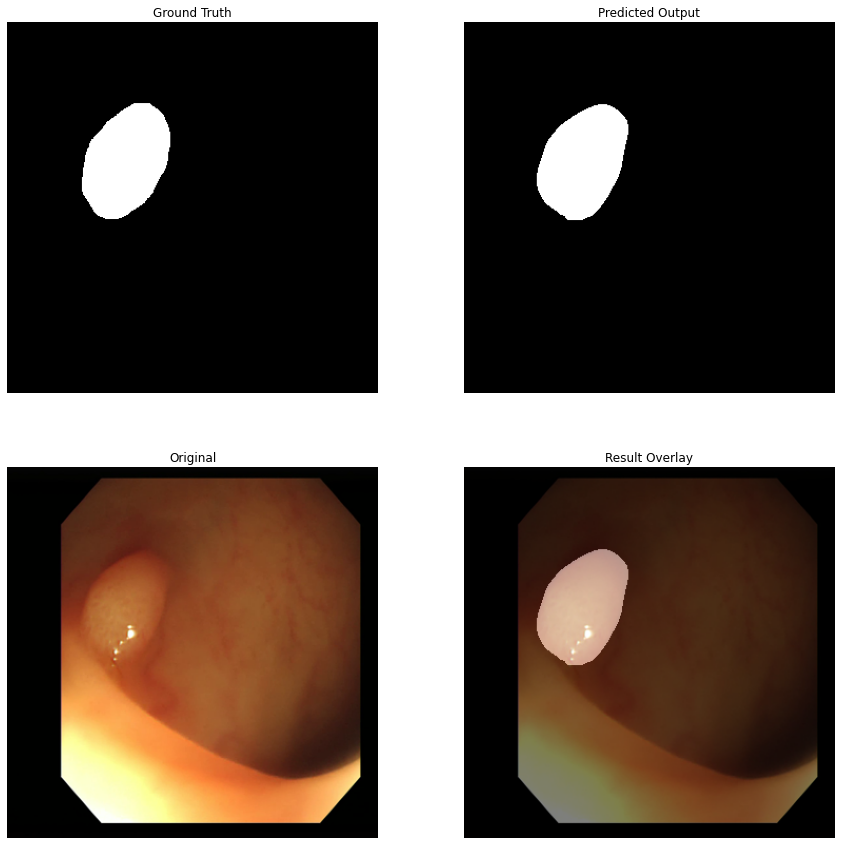

In [46]:
show_image(20, 0.5)

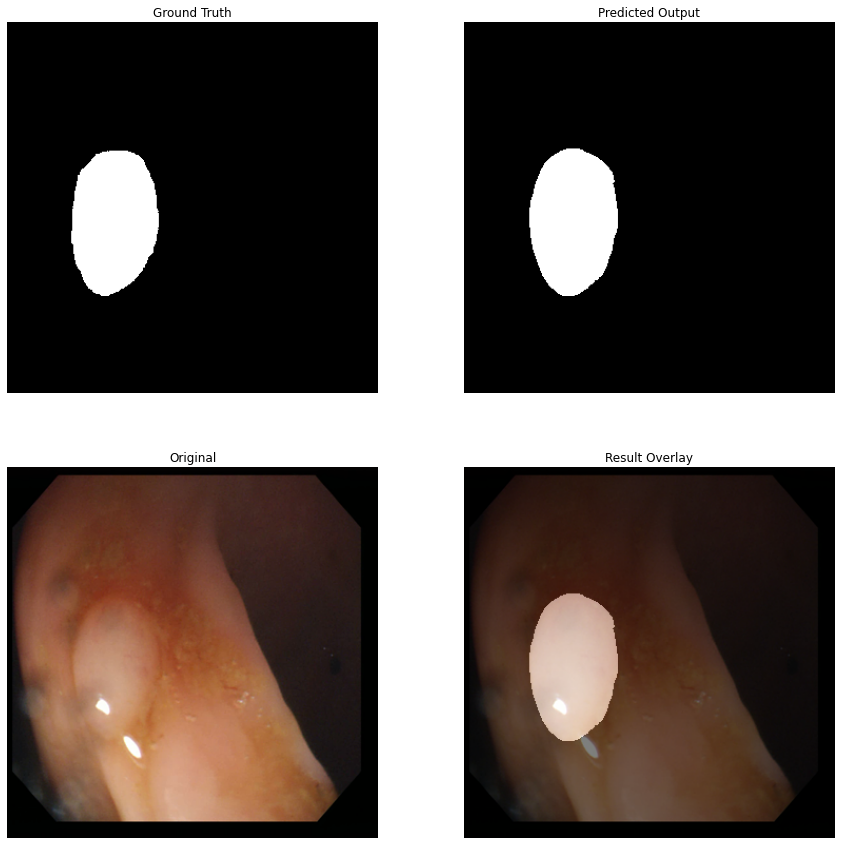

In [47]:
show_image(1, 0.5)

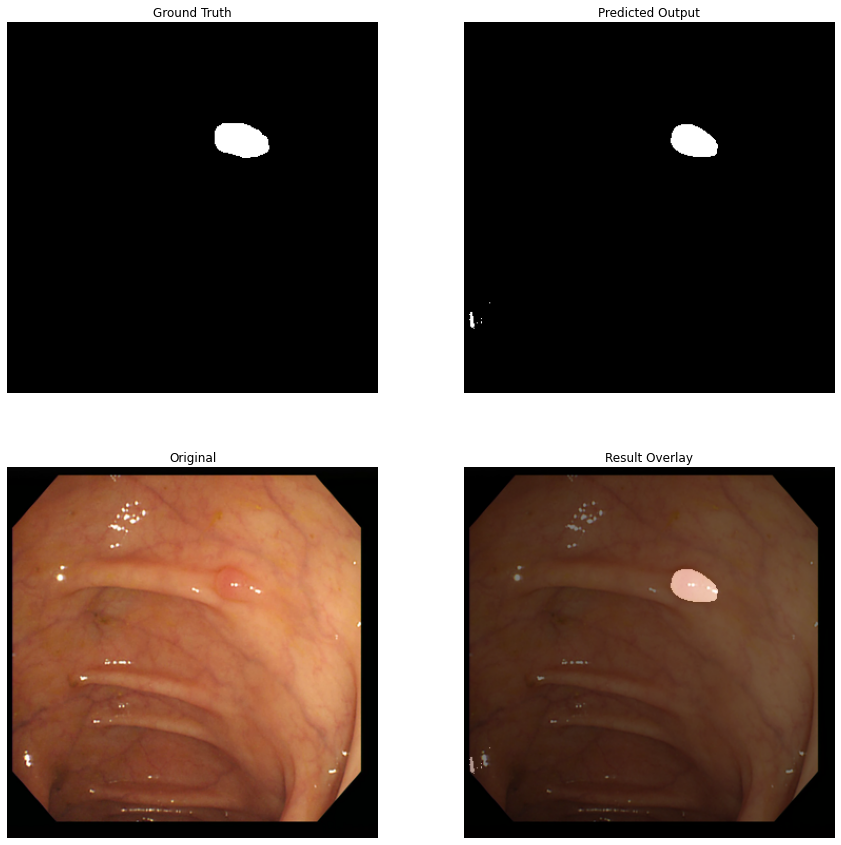

In [50]:
show_image(256, 0.5)

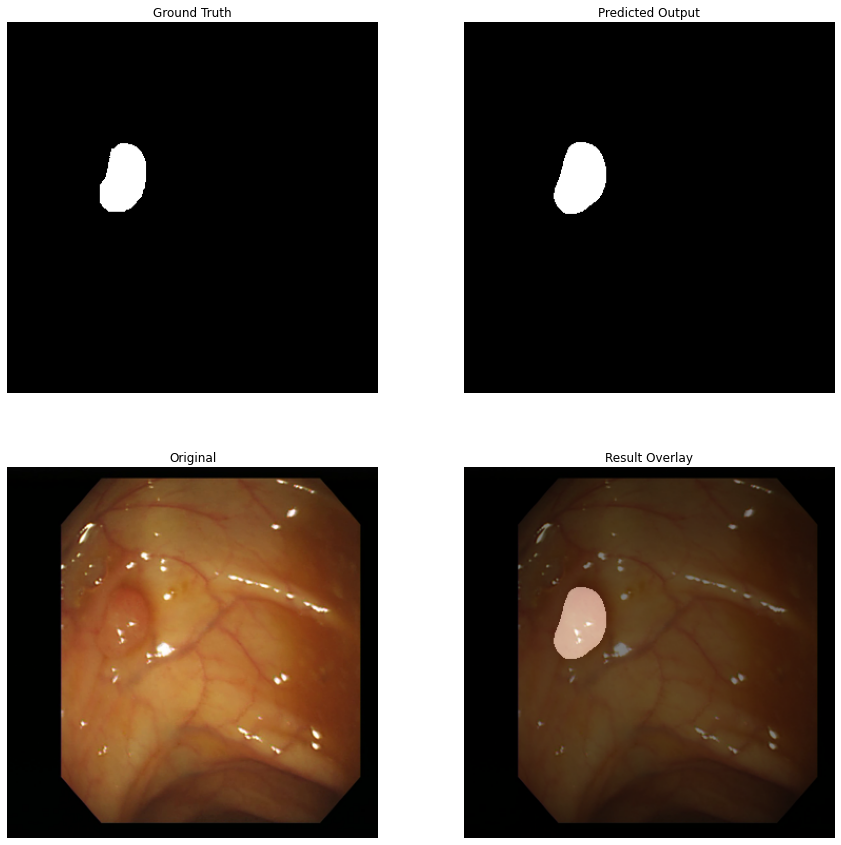

In [52]:
show_image(111, 0.5)

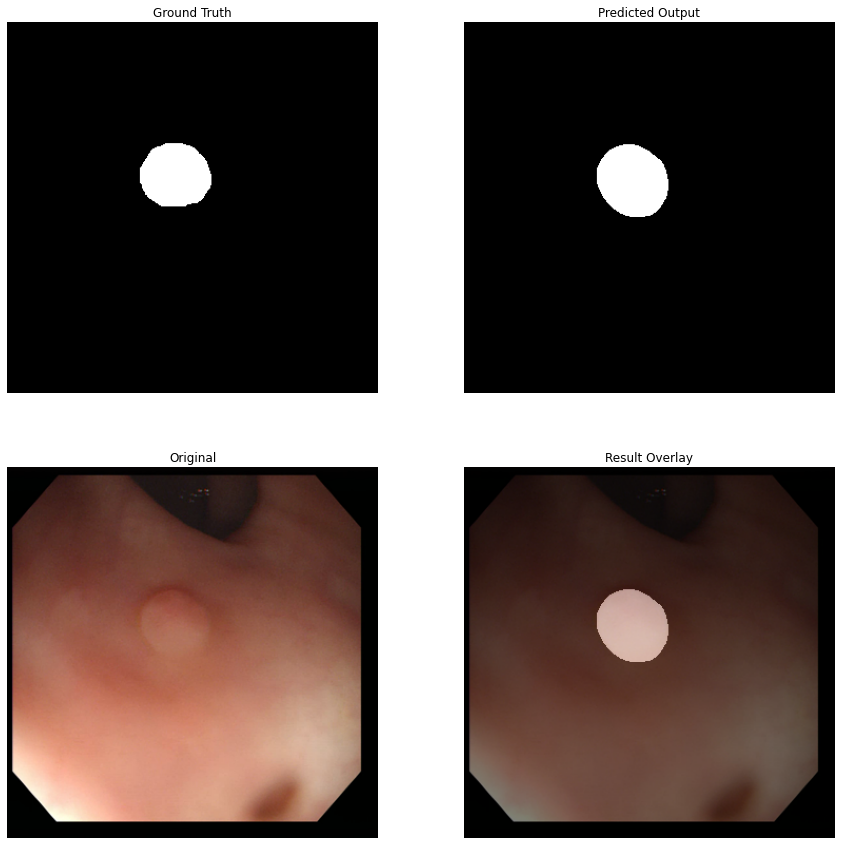

In [54]:
show_image(299, 0.5)

완벽하진 않지만 많이 근접하게 출력됨을 확인할수있다.

시간이 부족하여 추가적인 학습 및 시도를 못해본 점이 아쉽고, 최적의 th를 찾다 보면 iou 0.7 이상과 더 좋은 이미지들을 출력할 수 있을것 같다.

Polyp 탐지에서 segmentation label 이 없는 경우는 의사를 섭외하여 라벨링 하기에 너무 cost가 높아서 비지도학습을 통해 모델이 스스로 패턴을 찾아서 용종을 찾는 시도를 해볼수 있을것 같습니다. 
object detection 와 같이 낮은 차원의 label 만 있을 경우에는 OD를 진행하여 iou를 찾고 acc를 계산하는 방법 혹은 label 내부를 어떻게 잘 패턴을 찾고 학습하는 방법...... 
잘 모르겠습니다....